# TOC

__Chapter 5 - Feature selection__

1. [Import](#Import)
1. [Achieving better performance in feature engineering](#Achieving-better-performance-in-feature-engineering)
    1. [A case study – a credit card defaulting dataset](#A-case-study-a-credit-card-defaulting-dataset)
        1. [Creating a baseline machine learning pipeline](#Creating-a-baseline-machine-learning-pipeline)
1. [The types of feature selection](#The-types-of-feature-selection)
    1. [Statistical-based feature selection](#Statistical-based-feature-selection)
        1. [Correlation coefficients](#Correlation-coefficients)
        1. [Hypothesis testing](#Hypothesis-testing)
    1. [Model-based feature selection](#Model-based-feature-selection)
        1. [Tree-based methods](#Tree-based-methods)
        1. [Linear models and regularization](#Linear-models-and-regularization)
    1. [Choosing the right feature selection method](#Choosing-the-right-feature-selection-method)

# Import

<a id = 'Import'></a>

In [3]:
# standard libary and settings
import os
import sys
import importlib
import itertools
import warnings

warnings.simplefilter("ignore")
sys.path.append(modulePath) if modulePath not in sys.path else None
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree
import sklearn.utils as utils

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

# Achieving better performance in feature engineering

_Better_ is define as:
- Improved model performance
- Reduced training and predicting time


<a id = 'Achieving-better-performance-in-feature-engineering'></a>

In [4]:
#


def get_best_model_and_accuracy(model, params, X, y):
    grid = model_selection.GridSearchCV(model, params, error_score=0.0)
    grid.fit(X, y)
    print("Best Accuracy: {}".format(grid.best_score_))
    print("Best Parameters: {}".format(grid.best_params_))
    print(
        "Average Time to Fit (s): {}".format(
            round(grid.cv_results_["mean_fit_time"].mean(), 3)
        )
    )
    print(
        "Average Time to Score (s): {}".format(
            round(grid.cv_results_["mean_score_time"].mean(), 3)
        )
    )

## A case study – a credit card defaulting dataset

<a id = 'A-case-study-a-credit-card-defaulting-dataset'></a>

In [6]:
#

np.random.seed(123)

df = pd.read_csv("s3://tdp-ml-datasets/misc/CreditCardDefaults.csv")
df.info()
display(df[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5                     30000 non-null int64
BILL_AMT6               

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
#

df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,"30,000.000000","15,000.500000","8,660.398374",1.000000,"7,500.750000","15,000.500000","22,500.250000","30,000.000000"
LIMIT_BAL,"30,000.000000","167,484.322667","129,747.661567","10,000.000000","50,000.000000","140,000.000000","240,000.000000","1,000,000.000000"
SEX,"30,000.000000",1.603733,0.489129,1.000000,1.000000,2.000000,2.000000,2.000000
EDUCATION,"30,000.000000",1.853133,0.790349,0.000000,1.000000,2.000000,2.000000,6.000000
MARRIAGE,"30,000.000000",1.551867,0.521970,0.000000,1.000000,2.000000,2.000000,3.000000
AGE,"30,000.000000",35.485500,9.217904,21.000000,28.000000,34.000000,41.000000,79.000000
PAY_0,"30,000.000000",-0.016700,1.123802,-2.000000,-1.000000,0.000000,0.000000,8.000000
PAY_2,"30,000.000000",-0.133767,1.197186,-2.000000,-1.000000,0.000000,0.000000,8.000000
PAY_3,"30,000.000000",-0.166200,1.196868,-2.000000,-1.000000,0.000000,0.000000,8.000000
PAY_4,"30,000.000000",-0.220667,1.169139,-2.000000,-1.000000,0.000000,0.000000,8.000000


In [8]:
#

X = df.drop("default payment next month", axis=1)
y = df["default payment next month"]

In [9]:
# Null accuracy

y.value_counts(normalize=True)

0   0.778800
1   0.221200
Name: default payment next month, dtype: float64

### Creating a baseline machine learning pipeline

<a id = 'Creating-a-baseline-machine-learning-pipeline'></a>

In [10]:
# Instantiate models
# Define parameters for GridSearch

lr = linear_model.LogisticRegression()
lr_params = {"C": [1e-1, 1e0, 1e1, 1e2], "penalty": ["l1", "l2"]}

knn = neighbors.KNeighborsClassifier()
knn_params = {"n_neighbors": [1, 3, 5, 7]}

d_tree = tree.DecisionTreeClassifier()
tree_params = {"max_depth": [None, 1, 3, 5, 7]}

forest = ensemble.RandomForestClassifier()
forest_params = {"n_estimators": [10, 50, 100], "max_depth": [None, 1, 3, 5, 7]}

In [11]:
# Logistic regression

get_best_model_and_accuracy(lr, lr_params, X, y)

Best Accuracy: 0.8081333333333334
Best Parameters: {'C': 10.0, 'penalty': 'l1'}
Average Time to Fit (s): 0.508
Average Time to Score (s): 0.003


In [12]:
# KNN

# standard scale first

knn_pipe_params = {"classifier__{}".format(k): v for k, v in knn_params.items()}
knn_pipe = pipeline.Pipeline(
    [("scale", preprocessing.StandardScaler()), ("classifier", knn)]
)
get_best_model_and_accuracy(knn_pipe, knn_pipe_params, X, y)

print(knn_pipe_params)

Best Accuracy: 0.8001333333333334
Best Parameters: {'classifier__n_neighbors': 7}
Average Time to Fit (s): 0.04
Average Time to Score (s): 7.05
{'classifier__n_neighbors': [1, 3, 5, 7]}


In [13]:
# d_tree

get_best_model_and_accuracy(d_tree, tree_params, X, y)

Best Accuracy: 0.8196
Best Parameters: {'max_depth': 1}
Average Time to Fit (s): 0.171
Average Time to Score (s): 0.003


In [14]:
# random forest

get_best_model_and_accuracy(forest, forest_params, X, y)

Best Accuracy: 0.8061666666666667
Best Parameters: {'max_depth': 3, 'n_estimators': 100}
Average Time to Fit (s): 1.261
Average Time to Score (s): 0.045


> Remarks - All models beat the null accuracy, and the best model is the decision tree with 0.8196 accuracy. 

# The types of feature selection

There are two broad categories of feature selection:
- Statistical-based
- Model-based

<a id = 'The-types-of-feature-selection'></a>

## Statistical-based feature selection

<a id = 'Statistical-based-feature-selection'></a>

### Correlation coefficients

<a id = 'Correlation-coefficients'></a>

In [15]:
#

df.corr()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,1.000000,0.026179,0.018497,0.039177,-0.029079,0.018678,-0.030575,-0.011215,-0.018494,-0.002735,-0.022199,-0.020270,0.019389,0.017982,0.024354,0.040351,0.016705,0.016730,0.009742,0.008406,0.039151,0.007793,0.000652,0.003000,-0.013952
LIMIT_BAL,0.026179,1.000000,0.024755,-0.219161,-0.108139,0.144713,-0.271214,-0.296382,-0.286123,-0.267460,-0.249411,-0.235195,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595,-0.153520
SEX,0.018497,0.024755,1.000000,0.014232,-0.031389,-0.090874,-0.057643,-0.070771,-0.066096,-0.060173,-0.055064,-0.044008,-0.033642,-0.031183,-0.024563,-0.021880,-0.017005,-0.016733,-0.000242,-0.001391,-0.008597,-0.002229,-0.001667,-0.002766,-0.039961
EDUCATION,0.039177,-0.219161,0.014232,1.000000,-0.143464,0.175061,0.105364,0.121566,0.114025,0.108793,0.097520,0.082316,0.023581,0.018749,0.013002,-0.000451,-0.007567,-0.009099,-0.037456,-0.030038,-0.039943,-0.038218,-0.040358,-0.037200,0.028006
MARRIAGE,-0.029079,-0.108139,-0.031389,-0.143464,1.000000,-0.414170,0.019917,0.024199,0.032688,0.033122,0.035629,0.034345,-0.023472,-0.021602,-0.024909,-0.023344,-0.025393,-0.021207,-0.005979,-0.008093,-0.003541,-0.012659,-0.001205,-0.006641,-0.024339
AGE,0.018678,0.144713,-0.090874,0.175061,-0.414170,1.000000,-0.039447,-0.050148,-0.053048,-0.049722,-0.053826,-0.048773,0.056239,0.054283,0.053710,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478,0.013890
PAY_0,-0.030575,-0.271214,-0.057643,0.105364,0.019917,-0.039447,1.000000,0.672164,0.574245,0.538841,0.509426,0.474553,0.187068,0.189859,0.179785,0.179125,0.180635,0.176980,-0.079269,-0.070101,-0.070561,-0.064005,-0.058190,-0.058673,0.324794
PAY_2,-0.011215,-0.296382,-0.070771,0.121566,0.024199,-0.050148,0.672164,1.000000,0.766552,0.662067,0.622780,0.575501,0.234887,0.235257,0.224146,0.222237,0.221348,0.219403,-0.080701,-0.058990,-0.055901,-0.046858,-0.037093,-0.036500,0.263551
PAY_3,-0.018494,-0.286123,-0.066096,0.114025,0.032688,-0.053048,0.574245,0.766552,1.000000,0.777359,0.686775,0.632684,0.208473,0.237295,0.227494,0.227202,0.225145,0.222327,0.001295,-0.066793,-0.053311,-0.046067,-0.035863,-0.035861,0.235253
PAY_4,-0.002735,-0.267460,-0.060173,0.108793,0.033122,-0.049722,0.538841,0.662067,0.777359,1.000000,0.819835,0.716449,0.202812,0.225816,0.244983,0.245917,0.242902,0.239154,-0.009362,-0.001944,-0.069235,-0.043461,-0.033590,-0.026565,0.216614


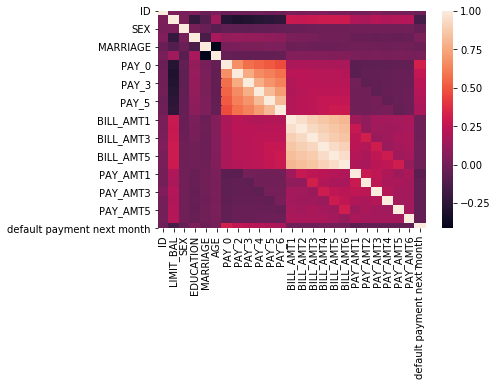

In [16]:
# correlation heatmap
sns.heatmap(df.corr())

> Remarks - We want to know which features are most strongly correlated with the target. We also want to identify feature interactions and redundancies, which need to be removed in order to avoid potential overfitting.

In [17]:
# review target's correlation coefficients > abs(.2)
df.corr()["default payment next month"].abs() > 0.2

ID                            False
LIMIT_BAL                     False
SEX                           False
EDUCATION                     False
MARRIAGE                      False
AGE                           False
PAY_0                          True
PAY_2                          True
PAY_3                          True
PAY_4                          True
PAY_5                          True
PAY_6                         False
BILL_AMT1                     False
BILL_AMT2                     False
BILL_AMT3                     False
BILL_AMT4                     False
BILL_AMT5                     False
BILL_AMT6                     False
PAY_AMT1                      False
PAY_AMT2                      False
PAY_AMT3                      False
PAY_AMT4                      False
PAY_AMT5                      False
PAY_AMT6                      False
default payment next month     True
Name: default payment next month, dtype: bool

In [18]:
# capture columns names of highly correlated features
highly_correlated_features = df.columns[
    df.corr()["default payment next month"].abs() > 0.2
]
highly_correlated_features

Index(['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'default payment next month'],
      dtype='object')

In [19]:
# create subset dataframe using only highly correlated features
X_subsetted = X[highly_correlated_features[:-1]]
X_subsetted[:5]

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5
0,2,2,-1,-1,-2
1,-1,2,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,-1,0,-1,0,0


In [20]:
# decision tree
get_best_model_and_accuracy(d_tree, tree_params, X_subsetted, y)

Best Accuracy: 0.8196666666666667
Best Parameters: {'max_depth': 3}
Average Time to Fit (s): 0.011
Average Time to Score (s): 0.002


> Remarks - Barely worse, much faster to fit

In [21]:
# custom class to perform the above operations
class CustomCorrelationChooser(base.TransformerMixin, base.BaseEstimator):
    def __init__(self, response, cols_to_keep=[], threshold=None):

        self.response = response
        self.threshold = threshold
        self.cols_to_keep = cols_to_keep

    def transform(self, X):
        return X[self.cols_to_keep]

    def fit(self, X, *_):
        df = pd.concat([X, self.response], axis=1)
        self.cols_to_keep = df.columns[df.corr()[df.columns[-1]].abs() > self.threshold]
        self.cols_to_keep = [c for c in self.cols_to_keep if c in X.columns]
        return self

In [22]:
# capture columns to keep
ccc = CustomCorrelationChooser(threshold=0.2, response=y)
ccc.fit(X)
ccc.cols_to_keep

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5']

In [23]:
# transform original dataset
ccc.transform(X)[:5]

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5
0,2,2,-1,-1,-2
1,-1,2,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,-1,0,-1,0,0


In [24]:
# combine into a pipeline
ccc = CustomCorrelationChooser(response=y)
ccc_pipe = pipeline.Pipeline([("correlation_select", ccc), ("classifier", d_tree)])
# ccc_params = deepcopy(tree_params)
ccc_params = {
    "correlation_select__threshold": [0, 0.1, 0.2, 0.3],
    "classifier__max_depth": [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
}
print(ccc_params)

get_best_model_and_accuracy(ccc_pipe, ccc_params, X, y)

{'correlation_select__threshold': [0, 0.1, 0.2, 0.3], 'classifier__max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
Best Accuracy: 0.8206
Best Parameters: {'classifier__max_depth': 5, 'correlation_select__threshold': 0.1}
Average Time to Fit (s): 0.113
Average Time to Score (s): 0.004


### Hypothesis testing

We test the null hypothesis of "This feature has no relevance to the response variable."

Two sklearn tools will be helpful in accomplishing this: SelectKBest and f_classif. SelectKBest select the top k features according to a chosen scoring function. f_classif performs a test called ANOVA, or analysis of variance. This is a type of hypothesis test that will be performed on each feature and assign each feature a p-value.
`
$Chi^2$ and regression are additional tests that can be used.

<a id = 'Hypothesis-testing'></a>

In [25]:
# perform SelectKBest using f_classif, return array containing top 5 features
X = X.iloc[:, 1:]
k_best = feature_selection.SelectKBest(feature_selection.f_classif, k=5)
k_best.fit_transform(X, y)

array([[ 2,  2, -1, -1, -2],
       [-1,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [-1,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 0, -1, -1,  0,  0],
       [ 0,  0,  2,  0,  0],
       [-2, -2, -2, -2, -1],
       [ 0,  0,  2,  0,  0],
       [-1, -1, -1, -1, -1],
       [-1,  0, -1, -1, -1],
       [ 1,  2,  2,  0,  0],
       [ 0,  0,  0,  0,  0],
       [ 1,  2,  0,  0,  0],
       [ 0,  0,  2,  2,  2],
       [ 0,  0,  0, -1, -1],
       [ 1, -2, -2, -2, -2],
       [ 1, -2, -2, -2, -2],
       [ 0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1],
       [ 2,  0,  0,  2,  2],
       [-2, -2, -2, -2, -2],
       [ 0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0],
       [ 1, -2, -1, -1, -1],
       [ 0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1],
       [ 2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0],
       [-2, -2, -2, -2, -2],
       [-2, -2

In [26]:
# inspect the p-values and return 5 highest
pvalue_df = pd.DataFrame({"columns": X.columns, "p-value": k_best.pvalues_}).sort_values(
    "p-value"
)
pvalue_df[:5]

,columns,p-value
5,PAY_0,0.000000
6,PAY_2,0.000000
7,PAY_3,0.000000
8,PAY_4,0.000000
9,PAY_5,0.000000


In [27]:
# return columns with pvalues > .05
pvalue_df[pvalue_df["p-value"] > 0.05]

,columns,p-value
14,BILL_AMT4,0.078556
15,BILL_AMT5,0.241634
16,BILL_AMT6,0.352123


In [28]:
# incorporate into grid search using pipline
k_best = feature_selection.SelectKBest(feature_selection.f_classif)
select_k_pipe = pipeline.Pipeline([("k_best", k_best), ("classifier", d_tree)])

params = {"classifier__max_depth": [None, 1, 3, 5, 7], "k_best__k": range(1, 23)}

get_best_model_and_accuracy(select_k_pipe, params, X, y)

Best Accuracy: 0.8206
Best Parameters: {'classifier__max_depth': 5, 'k_best__k': 7}
Average Time to Fit (s): 0.074
Average Time to Score (s): 0.003


## Model-based feature selection

<a id = 'Model-based-feature-selection'></a>

### Tree-based methods

Tree-based models split observations at nodes, and need to choose the optimal feature to use when performing that split. The selection criteria is called feature performance.

<a id = 'Tree-based-methods'></a>

In [29]:
# fit simple decision tree
import sklearn.tree as tree

simple_tree = tree.DecisionTreeClassifier()
simple_tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [30]:
# reate dataframe summarizing feature importance
importances = pd.DataFrame(
    {"importance": simple_tree.feature_importances_, "feature": X.columns}
).sort_values("importance", ascending=False)
importances[:5]

,importance,feature
5,0.161668,PAY_0
11,0.070230,BILL_AMT1
4,0.068866,AGE
0,0.062013,LIMIT_BAL
16,0.055560,BILL_AMT6


> Remarks - Different features than what was chosen by the hypothesis test method.

In [31]:
# use SelectFromModel to select the top K features based
# on feature importance
select_from_model = feature_selection.SelectFromModel(
    tree.DecisionTreeClassifier(), threshold=0.05
)
selected_X = select_from_model.fit_transform(X, y)
selected_X.shape

(30000, 8)

> Remarks - Returns a dataframe with the 9 features that have a feature importance value > 0.05

In [32]:
# GridSearch pipeline
tree_params = {"classifier__max_depth": [1, 3, 5, 7]}

select = feature_selection.SelectFromModel(tree.DecisionTreeClassifier())
pipe = pipeline.Pipeline([("select", select), ("classifier", d_tree)])

params = {
    "classifier__max_depth": [None, 1, 3, 5, 7],
    "select__threshold": [
        0.01,
        0.05,
        0.1,
        0.2,
        0.25,
        0.3,
        0.4,
        0.5,
        0.6,
        "mean",
        "median",
        "2.*mean",
    ],
    "select__estimator__max_depth": [None, 1, 3, 5, 7],
}

get_best_model_and_accuracy(pipe, params, X, y)

Best Accuracy: 0.8202666666666667
Best Parameters: {'classifier__max_depth': 3, 'select__estimator__max_depth': None, 'select__threshold': 0.01}
Average Time to Fit (s): 0.184
Average Time to Score (s): 0.002


> Remarks - In the parameters, we included reserved words such as mean, which only selects features with an importance that is higher than average. Median only selectes features that have an importance value higher than the median value. Lastly, 2.\*mean only selects features twice as important as the mean importance value.

In [33]:
# use get_support() method of SelectFromModel to review which
# features were chosen
pipe.set_params(
    **{
        "select__threshold": 0.01,
        "select__estimator__max_depth": None,
        "classifier__max_depth": None,
    }
)
pipe.steps[0][1].fit(X, y)
X.columns[pipe.steps[0][1].get_support()]

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

> Remarks - The decision tree keep all but two features.

### Linear models and regularization

SelectFromModel works with an machine learning model that has a feature_importances or coef_ attribute. Tree based models expore the former, linear models the latter. Linear models use coefficients to represent the slope of the feature, i.e. how much it affects the response when that the feature's value changes by one unit. SelectFromModel equates this to feature importance.

We can also use lasso and ridge regularization methods to penalize features, which helps to prevent overfitting. This also helps SelectFromModel choose the more important feaures. Regularization also helps reduce multicollinearity effects. In particular, Lasso forces the coefficients of all but one of the multicollinear features to 0, which effectively performs features selection and reduces the potential for overfitting

<a id = 'Linear-models-and-regularization'></a>

In [34]:
# use SelectFromModel to identify the most important features to be passed to the decision tree for modeling
logistic_selector = feature_selection.SelectFromModel(linear_model.LogisticRegression())

regularization_pipe = pipeline.Pipeline(
    [("select", logistic_selector), ("classifier", d_tree)]
)

params = {
    "classifier__max_depth": [None, 1, 3, 5, 7],
    "select__threshold": [0.01, 0.05, 0.1, "mean", "median", "2.*mean"],
    "select__estimator__penalty": ["l1", "l2"],
}

get_best_model_and_accuracy(regularization_pipe, params, X, y)

Best Accuracy: 0.8212
Best Parameters: {'classifier__max_depth': 5, 'select__estimator__penalty': 'l1', 'select__threshold': 0.01}
Average Time to Fit (s): 0.836
Average Time to Score (s): 0.002


> Remarks - The best accuracy so far

In [35]:
# create model using params
regularization_pipe.set_params(
    **{
        "select__threshold": 0.01,
        "classifier__max_depth": 5,
        "select__estimator__penalty": "l1",
    }
)

regularization_pipe.steps[0][1].fit(X, y)

X.columns[regularization_pipe.steps[0][1].get_support()]

Index(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5'],
      dtype='object')

> Remarks - This logistic regression model kept most of the PAY columns, but also learned that SEX, EDUCATION, and MARRIAGE are meaningful features

In [36]:
# SVC approach
import sklearn.svm as svm

svc_selector = feature_selection.SelectFromModel(svm.LinearSVC())
svc_pipe = pipeline.Pipeline([("select", svc_selector), ("classifier", simple_tree)])

params = {
    "classifier__max_depth": [None, 1, 3, 5, 7],
    "select__threshold": [0.01, 0.05, 0.1, "mean", "median", "2.*mean"],
    "select__estimator__penalty": ["l1", "l2"],
    "select__estimator__loss": ["squared_hinge", "hinge"],
    "select__estimator__dual": [True, False],
}

get_best_model_and_accuracy(svc_pipe, params, X, y)

Best Accuracy: 0.8212333333333334
Best Parameters: {'classifier__max_depth': 5, 'select__estimator__dual': False, 'select__estimator__loss': 'squared_hinge', 'select__estimator__penalty': 'l1', 'select__threshold': 0.01}
Average Time to Fit (s): 1.062
Average Time to Score (s): 0.001


In [37]:
# create model using params
svc_pipe.set_params(
    **{
        "select__estimator__loss": "squared_hinge",
        "select__threshold": 0.01,
        "select__estimator__penalty": "l1",
        "classifier__max_depth": 5,
        "select__estimator__dual": False,
    }
)

svc_pipe.steps[0][1].fit(X, y)
X.columns[svc_pipe.steps[0][1].get_support()]

Index(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_5'], dtype='object')

> Remarks - This model performed better by only recognizing to remove the PAY_4

## Choosing the right feature selection method

Rules of thumb:
- If features are mostly object, start by trying to implement SelectKBest with a Chi$^2$ or a tree-based model selector.
- If features are mostly quantitative, use linear models as model-based selectors and rely on correlations to choose features based on a minute absolute value correlation coefficient.
- If the data presents a binary classification problem, a support vector classification model with a SelectFrom Model selector will fit nicely.
- EDA mixed with domain knowledge

<a id = 'Choosing-the-right-feature-selection-method'></a>